Here you can extract forces from manual calculations and see the force as a function of the CV

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

Force extraction script (based on integration script)

In [2]:
def extract_forces(dirs, start=35000, end=75000, size=2000, force_plot=False):
    '''
    Calculates the forces for a simulated system using block analysis. 
    Parameters:
    - dirs: folders in which the results (COLVAR files) are located, sorted from the lowest CV value to the highest
    - start: time from the beginning of umbrella sampling from which block analysis should begin (ps)
    - end: time at which block analysis should end (ps)
    - size: block size (ps)
    - force_plot: if True, it plots the force as a function of the CV
    Outputs:
    - forces for each given CV value (numpy array)
    - standard deviation of each force (numpy array)
    Requirements:
    - folders in which the results are located must be called the same as the CV value at the umbrella, e.g. 2.1: that defines the umbrellas; these folders must contain COLVAR files from PLUMED
    - the folders must also 
    - time resolution in the COLVAR file must be 1 ps for proper indexing
    '''
    
    # define the bins / blocks from input parameters, as well as the umbrella centers
    bins = np.arange(start, end, size)
    umbrellas = [float(u) for u in dirs]

    # initialise numpy arrays that will store n rows of m averaged binned forces (n=number of blocks; m=number of umbrellas to integrate)
    # each row will be an input for integration to get a separate free energy profile
    # std_err is the standard deviation of obtained free energy paths, it will contain n elements
    n_bins = len(bins)-1
    n_umbrellas = len(umbrellas)
    binned_forces = np.zeros(shape=(n_bins, n_umbrellas))
   
    # this is for staying in the same folder at the end
    this_dir = os.getcwd()

    # open each COLVAR file in the umbrella folder
    # nd will be used for indexing when replacing 0s with actual binned forces in the numpy array
    for nd, d in enumerate(dirs):
        os.chdir(d)
        print(f"Folder: {d}")

        # extract info about relevant parameters from COLVAR
        with open('COLVAR') as f:
            lines = f.readlines()[1:]

            # initialise the list storing forces from COLVAR
            force_raw = []

            # define the centre of the umbrella and the force constant from the last recorded value
            ref = float(lines[-1].strip().split()[4])
            kappa = float(lines[-1].strip().split()[6])

            # get the remaining params
            for l in lines:
                params = l.strip().split()

                # calculate the force as -k(com-com_ref)
                com_raw = float(params[1])
                force_raw.append(-kappa*(com_raw - ref))
                
            # calculate the average force per bin
            for i in range(n_bins):
                bin_start, bin_end = bins[i], bins[i+1]
                f_bin = np.mean(force_raw[bin_start:bin_end])

                # replace the zeros in the force matrix with the averaged values
                binned_forces[i][nd] = f_bin
        
        os.chdir('../')
        print("Changing directory...")

    # change back to the main directory
    os.chdir(this_dir)
    
    # averaged free energy profile
    final_force = np.average(binned_forces, axis=0)
    std_dev = np.std(binned_forces, axis=0)

    if force_plot:
        # plot the results, normal
        pl, ax = plt.subplots(figsize=(12,12))
        ax.plot(umbrellas, final_force)
        ax.plot(umbrellas, final_force+std_dev)
        ax.plot(umbrellas, final_force-std_dev)
        ax.set_title('Forces (avg)')
        ax.set_xlabel('COM separation / nm')
        ax.set_ylabel('Force / kcal/mol')
        pl.show()
        pl.savefig('forceplot.png')

    return final_force, std_dev


Example usage:

Folder: 1.6
Changing directory...
Folder: 2.1
Changing directory...
Folder: 2.6
Changing directory...
Folder: 3.1
Changing directory...
Folder: 3.6
Changing directory...
Folder: 4.1


Changing directory...
Folder: 4.6
Changing directory...
Folder: 5.1
Changing directory...
Folder: 5.6
Changing directory...
Folder: 6.1
Changing directory...
Folder: 6.6
Changing directory...


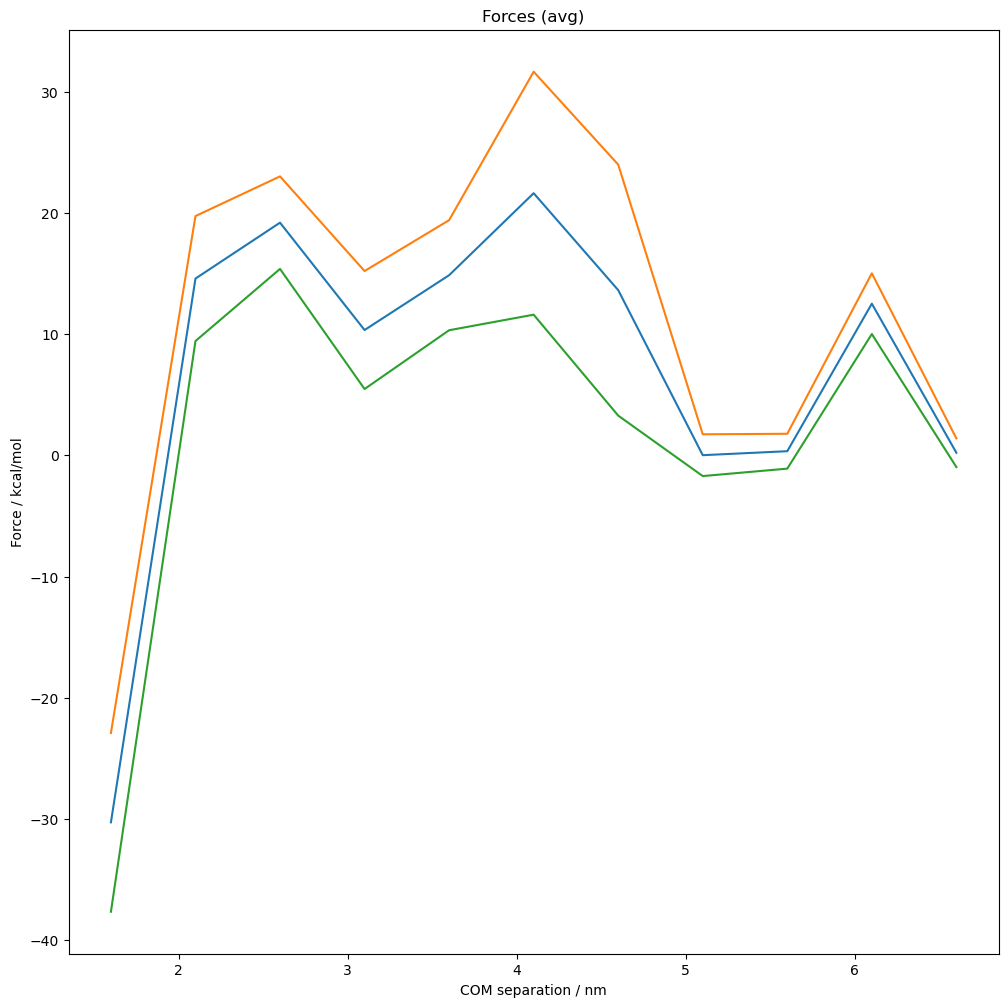

In [3]:
os.chdir('/home/fkopczynski/results/protein_Ca/plumed/umbrella/')
umb = sorted([x for x in os.listdir() if os.path.isdir(x)])
force, std = extract_forces(dirs=umb, force_plot=True)

In [4]:
# forces and standard deviations
for n, el in enumerate(force):
    print(f"Force for COM sep. = {umb[n]} nm: \t {el} +/- {std[n]} kcal/mol")

Force for COM sep. = 1.6 nm: 	 -30.268820789473633 +/- 7.372733042253456 kcal/mol
Force for COM sep. = 2.1 nm: 	 14.579715052631622 +/- 5.152471100669416 kcal/mol
Force for COM sep. = 2.6 nm: 	 19.190460644736888 +/- 3.81617237130271 kcal/mol
Force for COM sep. = 3.1 nm: 	 10.33424946052636 +/- 4.864787694928202 kcal/mol
Force for COM sep. = 3.6 nm: 	 14.856456881578996 +/- 4.538540396217118 kcal/mol
Force for COM sep. = 4.1 nm: 	 21.62012953947351 +/- 10.019362742201771 kcal/mol
Force for COM sep. = 4.6 nm: 	 13.628588289473507 +/- 10.351453203558986 kcal/mol
Force for COM sep. = 5.1 nm: 	 0.012775631578769259 +/- 1.722688953679811 kcal/mol
Force for COM sep. = 5.6 nm: 	 0.3406779078945591 +/- 1.437263568787464 kcal/mol
Force for COM sep. = 6.1 nm: 	 12.508910973684033 +/- 2.5045105801887257 kcal/mol
Force for COM sep. = 6.6 nm: 	 0.21452071052613803 +/- 1.1821792208289463 kcal/mol


Moving to block analysis, the next function is the variation of the first one but considers only 1 COLVAR file

In [5]:
def extract_force(umb, start=35000, end=50000, size=1000):
    '''
    Calculates the force for a simulated system. 
    Parameters:
    - umb: folder in which the result (COLVAR file) is located
    - start: time from the beginning of umbrella sampling from which block analysis should begin (ps)
    - end: time at which block analysis should end (ps)
    - size: block size (ps)
    Outputs:
    - forces for each given CV value (numpy array)
    - standard deviation of each force (numpy array)
    Requirements:
    - folder in which the results are located must be called the same as the CV value at the umbrella, e.g. 2.1: that defines the umbrellas
    - time resolution in COLVAR file must be 1 ps for indexing
    
    '''
    
    # define the bins / blocks from input parameters, as well as the umbrella centers
    bins = np.arange(start, end, size)

    # initialise numpy arrays that will store n rows of m averaged binned forces (n=number of blocks; m=number of umbrellas to integrate)
    # each row will be an input for integration to get a separate free energy profile
    # std_err is the standard deviation of obtained free energy paths, it will contain n elements
    n_bins = len(bins)-1
    binned_forces = np.zeros(n_bins)

    # open COLVAR file in the umbrella folder
    # extract info about relevant parameters from COLVAR
    os.chdir(str(umb))

    with open('COLVAR') as f:
        lines = f.readlines()[1:]

        # initialise the list storing forces from COLVAR
        force_raw = []

        # define the centre of the umbrella and the force constant from the last recorded value
        ref = float(lines[-1].strip().split()[4])
        kappa = float(lines[-1].strip().split()[6])

        # get the remaining params
        for l in lines:
            params = l.strip().split()

            # calculate the force as -k(com-com_ref)
            com_raw = float(params[1])
            force_raw.append(-kappa*(com_raw - ref))
            
        # calculate the average force per bin
        for i in range(n_bins):
            bin_start, bin_end = bins[i], bins[i+1]
            f_bin = np.mean(force_raw[bin_start:bin_end])

            # replace the zeros in the force matrix with the averaged values
            binned_forces[i] = f_bin

    os.chdir('../')
    # averaged free energy profile
    final_force = np.average(binned_forces)
    std = np.std(binned_forces)

    return std, final_force

Block analysis example

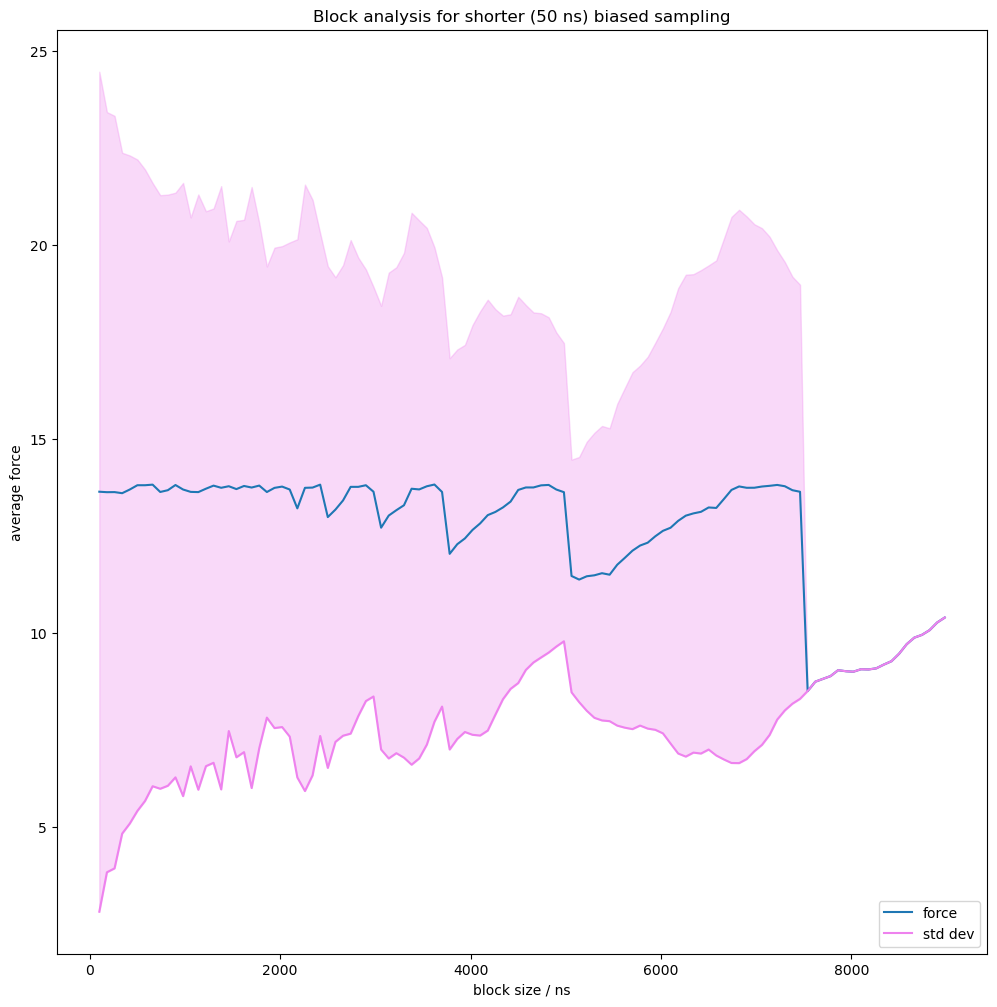

In [11]:
os.chdir('/home/fkopczynski/results/protein_Ca/plumed/umbrella/')

sizes = np.arange(100,9000,80)
nblocks = np.round(15000/sizes).astype(int)
nsizes = len(sizes)
lst_f = []
lst_std = []
for s in sizes:
    std, f = extract_force(umb=3.6, start=35000, end=50000, size=s)
    lst_f.append(f)
    lst_std.append(std)

avg_f = np.array(lst_f)
avg_std = np.array(lst_std)

pl, ax = plt.subplots(figsize=(12,12))
ax.plot(sizes, avg_f, label='force')
#ax.plot(sizes, avg_f+avg_std, 'r--', label='standard dev')
ax.plot(sizes, avg_f-avg_std, color='violet', label='std dev')
ax.fill_between(sizes, avg_f-avg_std, avg_f+avg_std, color='violet', alpha=0.3)
ax.set_ylabel('average force')
ax.set_xlabel('block size / ns')
ax.set_title('Block analysis for shorter (50 ns) biased sampling')
plt.legend(loc=4)
#plt.savefig('block_analysis.png')

Function below was used in Bayesian quadrature to approximate the mean function to the force plot shape

In [12]:
def f(x):
    y = np.zeros(len(x))
    for n, el in enumerate(x):
        el_i = float(el)
        if el_i < 5:
            y[n] = -6* (el_i-3.5)**2 + 25 
        else:
            y[n] = 0
    return y


[ 3.34 13.24 20.14 24.04 24.94 22.84 17.74  0.    0.    0.    0.  ]
<function f at 0x7fe338f0dda0>


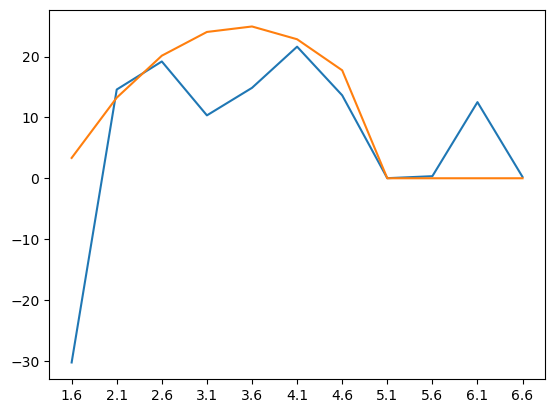

In [13]:
pl, ax = plt.subplots()

y = f(umb)
print(y)
print(f)

ax.plot(umb, force)
ax.plot(umb,y)
